In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
file_count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    file_count += len(filenames)

print(f"–í—Å—å–æ–≥–æ —Ñ–∞–π–ª—ñ–≤ —É /kaggle/input: {file_count}")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

–í—Å—å–æ–≥–æ —Ñ–∞–π–ª—ñ–≤ —É /kaggle/input: 2692


In [2]:
!pip install ultralytics > /dev/null

In [3]:
import os
import shutil
import torch
import torchvision
import matplotlib.pyplot as plt
import yaml
import cv2
import glob
import pandas as pd
import sys

from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from ultralytics import YOLO
from contextlib import contextmanager

Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
DATA_DIR = "/kaggle/input/indoor-object-detection"  # —à–ª—è—Ö –¥–æ –¥–∞—Ç–∞—Å–µ—Ç—É –Ω–∞ Kaggle

In [5]:
# –ü–µ—Ä–µ–≤—ñ—Ä–∫–∞ —Ñ–∞–π–ª—ñ–≤ —É –¥–∏—Ä–µ–∫—Ç–æ—Ä—ñ—è—Ö
print("–ü–∞–ø–∫–∏ —É –¥–∞—Ç–∞—Å–µ—Ç—ñ:", os.listdir(DATA_DIR))
print("–ü–∞–ø–∫–∞ train/images:", os.listdir(os.path.join(DATA_DIR, "train", "images"))[:5])

# –ß–∏—Ç–∞—î–º–æ data.yaml, —è–∫–∏–π –ø–æ–≤–∏–Ω–µ–Ω –±—É—Ç–∏ —É –¥–∞—Ç–∞—Å–µ—Ç—ñ –∞–±–æ —Å—Ç–≤–æ—Ä–∏–º–æ –ª–æ–∫–∞–ª—å–Ω–æ
yaml_path = "./data.yaml"

–ü–∞–ø–∫–∏ —É –¥–∞—Ç–∞—Å–µ—Ç—ñ: ['data.yaml', 'valid', 'test', 'train']
–ü–∞–ø–∫–∞ train/images: ['263523d1754e3381.jpg', '1ae7acb4547d5bc0.jpg', '0e8139635a72ecb8.jpg', 'a0da5e7cc4ba2d79.jpg', '0410943ef1919f80.jpg']


In [6]:
if os.path.exists(yaml_path):
    print(f"–§–∞–π–ª '{yaml_path}' –≤–∂–µ —ñ—Å–Ω—É—î. –ü–µ—Ä–µ–∑–∞–ø–∏—Å—É–≤–∞—Ç–∏ –Ω–µ –±—É–¥–µ–º–æ.")
else:
    data_yaml = f"""
train: {DATA_DIR}/train/images
val: {DATA_DIR}/valid/images
test: {DATA_DIR}/test/images
nc: 10
names:
  - door
  - cabinetDoor
  - refrigeratorDoor
  - window
  - chair
  - table
  - cabinet
  - couch
  - openedDoor
  - pole
"""
    with open(yaml_path, "w") as f:
        f.write(data_yaml)
    print("–§–∞–π–ª data.yaml —Å—Ç–≤–æ—Ä–µ–Ω–æ")

–§–∞–π–ª data.yaml —Å—Ç–≤–æ—Ä–µ–Ω–æ


In [7]:
# –ó–∞–≤–∞–Ω—Ç–∞–∂—É—î–º–æ –Ω–∞–∑–≤–∏ –∫–ª–∞—Å—ñ–≤
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
class_names = data['names']

# –§—É–Ω–∫—Ü—ñ—è –¥–ª—è –≤—ñ–¥–æ–±—Ä–∞–∂–µ–Ω–Ω—è bounding box —ñ–∑ YOLO –∞–Ω–æ—Ç–∞—Ü—ñ–π
def draw_yolo_bbox(image_path, label_path, class_names):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        cls, cx, cy, bw, bh = map(float, line.strip().split())
        cls = int(cls)

        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)

        cv2.rectangle(image,(x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, class_names[cls], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [8]:
test_dir = "/kaggle/input/indoor-object-detection/test"
print("–í–º—ñ—Å—Ç –ø–∞–ø–∫–∏ test:", os.listdir(test_dir))

–í–º—ñ—Å—Ç –ø–∞–ø–∫–∏ test: ['labels', 'images']


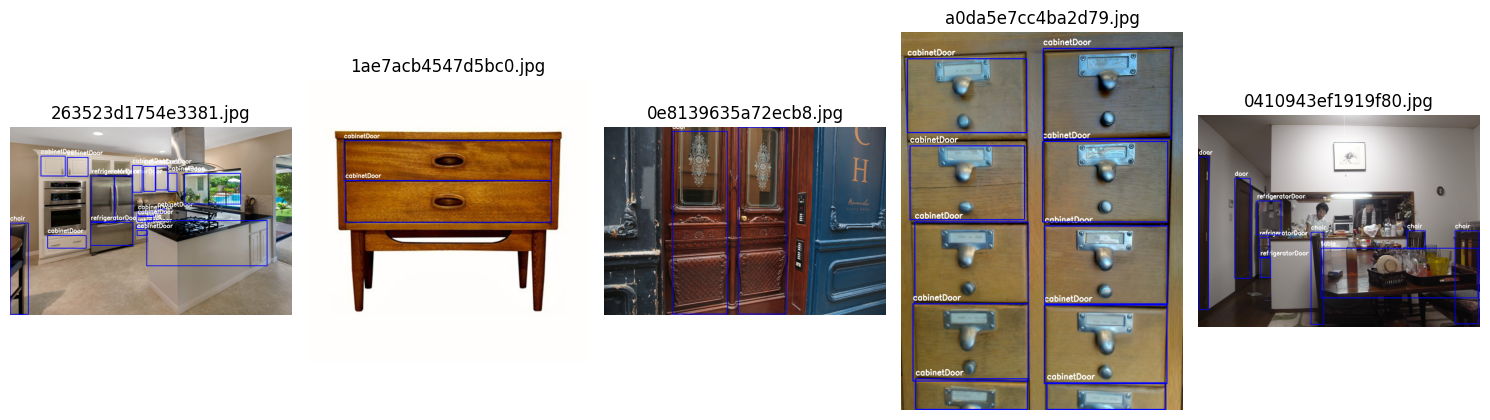

In [9]:
# –ü—Ä–∏–∫–ª–∞–¥ –≤—ñ–∑—É–∞–ª—ñ–∑–∞—Ü—ñ—ó 5 –∑–æ–±—Ä–∞–∂–µ–Ω—å –∑ —Ç—Ä–µ–Ω—É–≤–∞–ª—å–Ω–æ—ó –≤–∏–±—ñ—Ä–∫–∏
image_dir = os.path.join(DATA_DIR, "train", "images")
label_dir = os.path.join(DATA_DIR, "train", "labels")
image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))[:5]

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(image_paths):
    label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
    img = draw_yolo_bbox(img_path, label_path, class_names)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [28]:
# –Ü–Ω—ñ—Ü—ñ–∞–ª—ñ–∑–∞—Ü—ñ—è –º–æ–¥–µ–ª—ñ YOLOv8l
model = YOLO("yolov8m.pt")  # –ó–∞–º—ñ—Å—Ç—å yolov8s.pt —Å—Ç–∞–≤–∏–º–æ yolov8l.pt

# –ü–∞—Ä–∞–º–µ—Ç—Ä–∏ –∞—É–≥–º–µ–Ω—Ç–∞—Ü—ñ—ó (—è–∫—â–æ —Ö–æ—á–µ—à ‚Äî –∑–∞–ª–∏—à–∞—î–º–æ –±–µ–∑ –∑–º—ñ–Ω)
augmentations = {
    'blur': 0.05,
    'median_blur': 0.05,
    'clahe': 0.05,
    'rotate': 0.2,
    'brightness': 0.15,
    'contrast': 0.15,
    'flipud': 0.5,
    'fliplr': 0.5,
}

# –ù–∞–≤—á–∞–Ω–Ω—è
model.train(
    data=yaml_path,
    epochs=40,
    imgsz=640,
    batch=32, 
    lr0=0.0015,           
    project="/kaggle/working/indoor_yolo_training",
    name="yolov8m_indoor",
    exist_ok=True,
    augment=True,
    save=True,
    save_period=1,
    resume=False,
    verbose=False
)

Ultralytics 8.3.174 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_indoor, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1012/1012 [00:01<00:00, 767.17it/s]


WARNING ‚ö†Ô∏è train: Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ‚úÖ (ping: 0.0¬±0.0 ms, read: 214.1¬±64.1 MB/s, size: 217.7 KB)


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 230/230 [00:00<00:00, 953.54it/s]

WARNING ‚ö†Ô∏è val: Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.


Plotting labels to /kaggle/working/indoor_yolo_training/yolov8m_indoor/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/indoor_yolo_training/yolov8m_indoor
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      12.3G      1.688      2.992      1.565        180        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.06it/s]

                   all        230       1289        0.4      0.196      0.165     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.6G      1.451      1.732      1.349        173        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.33it/s]

                   all        230       1289      0.558      0.232      0.186     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.7G      1.456      1.737       1.37        154        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.30it/s]

                   all        230       1289      0.454       0.26      0.141     0.0749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.8G      1.476      1.756      1.397        160        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.31it/s]

                   all        230       1289      0.555      0.147       0.12     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.9G       1.46       1.66      1.383        189        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.25it/s]

                   all        230       1289      0.492      0.189      0.138     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.7G      1.448       1.61      1.371        144        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.34it/s]

                   all        230       1289      0.338      0.297      0.201      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.8G      1.412      1.484      1.356        150        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.35it/s]

                   all        230       1289      0.447      0.299      0.245      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.9G      1.399      1.487      1.368        228        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.34it/s]

                   all        230       1289       0.51      0.243      0.242      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.8G      1.378      1.388      1.316        197        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.34it/s]

                   all        230       1289      0.426      0.283      0.245      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.7G      1.351      1.407      1.326        163        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.34it/s]

                   all        230       1289      0.514      0.297      0.274      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      11.7G      1.353      1.336      1.317        258        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.36it/s]

                   all        230       1289      0.534      0.275      0.288       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      11.8G      1.303      1.274      1.292        178        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289      0.632      0.281      0.305      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      11.9G      1.296       1.23      1.297        212        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.406      0.353      0.292      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.8G      1.299      1.196       1.28        199        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289       0.71      0.358      0.443      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      11.9G      1.274      1.195      1.276        279        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.36it/s]

                   all        230       1289      0.415      0.321      0.321      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      11.6G      1.263      1.117      1.259        224        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289      0.479      0.346      0.354      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.8G      1.225      1.066      1.235        161        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.32it/s]

                   all        230       1289      0.321      0.405      0.361      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.9G       1.21      1.022      1.226        256        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.382      0.366      0.355      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.6G        1.2      1.024      1.227        236        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289      0.385      0.439      0.356      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.8G      1.177      1.002      1.214        313        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289      0.296      0.388      0.344      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.7G      1.177     0.9598      1.208        202        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289      0.399      0.361      0.336        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.8G       1.17     0.9328      1.202        185        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.408      0.382      0.359      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.9G      1.146     0.9133      1.199        160        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.32it/s]

                   all        230       1289      0.391      0.382      0.372      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.7G      1.121     0.8907      1.174        180        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.423      0.476      0.422      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.9G      1.089     0.8493      1.163        189        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.358      0.502      0.445      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.8G      1.095     0.8398      1.154        154        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.477      0.442      0.406      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.8G      1.071     0.8106       1.16        200        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.399      0.517      0.469      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.4G      1.063     0.7887      1.141        282        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.651      0.436      0.479      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.6G      1.052      0.757      1.136        135        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289      0.426      0.447      0.396      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.9G      1.025     0.7513      1.136        135        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.401      0.434      0.409      0.228


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.9G      1.039     0.7166      1.128        138        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289        0.4       0.53      0.427      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.9G     0.9912     0.6333      1.115        106        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.484      0.397      0.383      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.8G     0.9685      0.601      1.098        143        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.354      0.399      0.381      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.9G     0.9539     0.5857      1.088        104        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289      0.421      0.524      0.425      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.9G     0.9414     0.5625      1.082        108        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.644      0.391      0.476      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.8G     0.9119     0.5434      1.067        157        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289        0.4      0.483      0.409      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.8G     0.9021     0.5289       1.06        152        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.577      0.474      0.436      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.9G       0.87     0.4938      1.047        124        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.524      0.388      0.402      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.8G     0.8608     0.4893      1.032         79        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289       0.53      0.395      0.399      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.8G     0.8463     0.4841      1.035         73        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.415      0.406      0.402      0.248



40 epochs completed in 0.411 hours.
Optimizer stripped from /kaggle/working/indoor_yolo_training/yolov8m_indoor/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/working/indoor_yolo_training/yolov8m_indoor/weights/best.pt, 52.0MB

Validating /kaggle/working/indoor_yolo_training/yolov8m_indoor/weights/best.pt...
Ultralytics 8.3.174 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:06<00:00,  1.74s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        230       1289      0.766      0.405      0.495      0.333
Speed: 0.2ms preprocess, 22.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/indoor_yolo_training/yolov8m_indoor


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78e6109319d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [29]:
# –Ü–Ω—Ñ–µ—Ä–µ–Ω—Å –Ω–∞ —Ç–µ—Å—Ç–æ–≤–∏—Ö –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è—Ö
test_images_dir = "/kaggle/input/indoor-object-detection/test/images"
results = model.predict(
    source=test_images_dir, 
    save=True, 
    conf=0.25, 
    save_dir="/kaggle/working/indoor_yolo_training/inference_results"
)

print("–†–µ–∑—É–ª—å—Ç–∞—Ç–∏ —ñ–Ω—Ñ–µ—Ä–µ–Ω—Å—É –∑–±–µ—Ä–µ–∂–µ–Ω—ñ —É –ø–∞–ø–∫—É:", "/kaggle/working/indoor_yolo_training/inference_results")

Results saved to /kaggle/working/indoor_yolo_training/yolov8m_indoor
–†–µ–∑—É–ª—å—Ç–∞—Ç–∏ —ñ–Ω—Ñ–µ—Ä–µ–Ω—Å—É –∑–±–µ—Ä–µ–∂–µ–Ω—ñ —É –ø–∞–ø–∫—É: /kaggle/working/indoor_yolo_training/inference_results


In [30]:
metrics = model.val()
class_names = list(metrics.names.values())

# precision, recall, ap50, ap95 –ø–æ –∫–ª–∞—Å–∞—Ö –≤ metrics.box:
# p, r, ap50, ap95 ‚Äî —Ü–µ —Å–ø–∏—Å–∫–∏ –ø–æ –∫–ª–∞—Å–∞—Ö

data = {
    "Class": list(metrics.names.values()),
    "Precision": metrics.box.p.tolist(),  # precision –ø–æ –∫–ª–∞—Å–∞—Ö
    "Recall": metrics.box.r.tolist(),      # recall –ø–æ –∫–ª–∞—Å–∞—Ö
    "mAP@0.5": metrics.box.ap50.tolist(),  # mAP@0.5 –ø–æ –∫–ª–∞—Å–∞—Ö
    "mAP@0.5:0.95": metrics.box.ap.tolist()  # mAP@0.5:0.95 –ø–æ –∫–ª–∞—Å–∞—Ö
}

df = pd.DataFrame(data)
df.index.name = "Index"
print(df.round(3))

# –ó–±–µ—Ä–µ–∂–µ–Ω–Ω—è –º–µ—Ç—Ä–∏–∫ —É CSV
df.to_csv("/kaggle/working/indoor_metrics.csv", index=False)

Ultralytics 8.3.174 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ‚úÖ (ping: 0.0¬±0.0 ms, read: 659.1¬±507.7 MB/s, size: 411.9 KB)


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 230/230 [00:00<00:00, 732.12it/s]

WARNING ‚ö†Ô∏è val: Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:11<00:00,  1.42s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        230       1289      0.659      0.404      0.492      0.332
Speed: 2.0ms preprocess, 40.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/indoor_yolo_training/yolov8m_indoor
                  Class  Precision  Recall  mAP@0.5  mAP@0.5:0.95
Index                                                            
0                  door      0.720   0.474    0.578         0.377
1           cabinetDoor      0.891   0.685    0.828         0.481
2      refrigeratorDoor      0.883   0.709    0.837         0.558
3                window      0.428   0.214    0.304         0.180
4                 chair      0.769   0.475    0.633         0.354
5                 table      0.490   0.200    0.238         0.126
6               cabinet      0.762   0.281    0.399         0.288
7                 couch      0.648   1.000    0.995         0.896
8            openedDoor      0.000   0.000    0.079         0.048
9                  pole      1.00

In [31]:
print(f"üìä mAP@0.5: {metrics.box.map50:.4f}")
print(f"üìä mAP@0.5:0.95: {metrics.box.map:.4f}")

mean_precision = sum(metrics.box.p) / len(metrics.box.p)
mean_recall = sum(metrics.box.r) / len(metrics.box.r)
mean_f1 = sum(metrics.box.f1) / len(metrics.box.f1)

print(f"üìà Precision (mean –ø–æ –∫–ª–∞—Å–∞—Ö): {mean_precision:.4f}")
print(f"üìâ Recall (mean –ø–æ –∫–ª–∞—Å–∞—Ö): {mean_recall:.4f}")
print(f"‚úÖ F1-score (mean –ø–æ –∫–ª–∞—Å–∞—Ö): {mean_f1:.4f}")

üìä mAP@0.5: 0.4919
üìä mAP@0.5:0.95: 0.3319
üìà Precision (mean –ø–æ –∫–ª–∞—Å–∞—Ö): 0.6592
üìâ Recall (mean –ø–æ –∫–ª–∞—Å–∞—Ö): 0.4038
‚úÖ F1-score (mean –ø–æ –∫–ª–∞—Å–∞—Ö): 0.4486


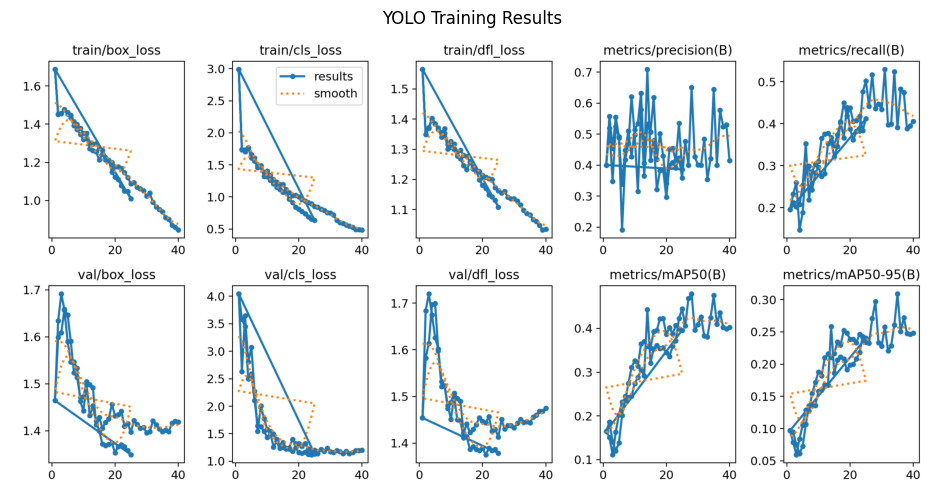

In [32]:
results_path = "/kaggle/working/indoor_yolo_training/yolov8m_indoor/results.png"

# –í—ñ–¥–∫—Ä–∏–≤–∞—î–º–æ —Ç–∞ –≤—ñ–¥–æ–±—Ä–∞–∂–∞—î–º–æ, —è–∫—â–æ —Ñ–∞–π–ª —ñ—Å–Ω—É—î
if os.path.exists(results_path):
    img = Image.open(results_path)
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("YOLO Training Results")
    plt.show()
else:
    print(f"‚ùå –§–∞–π–ª –Ω–µ –∑–Ω–∞–π–¥–µ–Ω–æ: {results_path}")

In [33]:
base_path = "/kaggle/working/indoor_yolo_training/yolov8m_indoor"
print("–§–∞–π–ª–∏ —É –¥–∏—Ä–µ–∫—Ç–æ—Ä—ñ—ó:")
print(os.listdir(base_path))

–§–∞–π–ª–∏ —É –¥–∏—Ä–µ–∫—Ç–æ—Ä—ñ—ó:
['1123.jpg', '1101.jpg', '1239.jpg', '1382.jpg', '1040.jpg', '923.jpg', '1095.jpg', '1058.jpg', '1187.jpg', '1137.jpg', '1113.jpg', '921.jpg', '1253.jpg', '1281.jpg', 'val_batch0_pred.jpg', 'confusion_matrix_normalized.png', '1048.jpg', '1357.jpg', '1119.jpg', '110.jpg', '1344.jpg', '1302.jpg', '1054.jpg', '1069.jpg', '1071.jpg', 'train_batch482.jpg', 'BoxR_curve.png', '1104.jpg', '1245.jpg', '1209.jpg', '908.jpg', '888.jpg', '127.jpg', '1015.jpg', '1339.jpg', '1122.jpg', '1021.jpg', '1027.jpg', '1154.jpg', '118.jpg', '1217.jpg', '1290.jpg', '126.jpg', '1278.jpg', 'train_batch2.jpg', '1026.jpg', '1089.jpg', '1338.jpg', '1032.jpg', '1079.jpg', '1342.jpg', '999.jpg', '1269.jpg', '1186.jpg', 'weights', 'val_batch1_pred.jpg', '1323.jpg', '1320.jpg', '1020.jpg', 'results.png', 'BoxF1_curve.png', '954.jpg', '1300.jpg', '925.jpg', 'val_batch1_labels.jpg', '1329.jpg', 'train_batch962.jpg', '1195.jpg', '1310.jpg', '1045.jpg', '1028.jpg', '1311.jpg', '1145.jpg

In [34]:
# –®–ª—è—Ö –¥–æ –º–µ—Ç—Ä–∏–∫ —É —Ñ–æ—Ä–º–∞—Ç—ñ txt –∞–±–æ JSON
metrics_path = "/kaggle/working/indoor_yolo_training/yolov8m_indoor/results.csv"

# –ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–æ, —è–∫—â–æ —î `metrics.json`:
# import json
# with open('/kaggle/working/runs/detect/train/metrics.json', 'r') as f:
#     metrics = json.load(f)

# –ß–∏—Ç–∞—î–º–æ CSV –º–µ—Ç—Ä–∏–∫, —è–∫—â–æ –≤—ñ–Ω —Å—Ç–≤–æ—Ä–∏–≤—Å—è
df = pd.read_csv(metrics_path)
df  # –ü–æ–∫–∞–∑—É—î–º–æ –æ—Å—Ç–∞–Ω–Ω—ñ –µ–ø–æ—Ö–∏ ‚Äî —Ç–∞–º –Ω–∞–π–∫—Ä–∞—â—ñ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏–∞–∑—É—î–º–æ –æ—Å—Ç–∞–Ω–Ω—ñ –µ–ø–æ—Ö–∏ ‚Äî —Ç–∞–º –Ω–∞–π–∫—Ä–∞—â—ñ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏

epoch       time  train/box_loss  train/cls_loss  train/dfl_loss  \
0       1    37.5617         1.68762         2.99224         1.56549   
1       2    75.6014         1.45285         1.74003         1.34871   
2       3   112.3890         1.45432         1.70431         1.37235   
3       4   149.5010         1.47427         1.77120         1.40248   
4       5   186.3270         1.45396         1.60568         1.38464   
..    ...        ...             ...             ...             ...   
60     36  1332.9200         0.91187         0.54339         1.06689   
61     37  1369.4600         0.90209         0.52890         1.06006   
62     38  1405.9000         0.87001         0.49380         1.04746   
63     39  1442.3800         0.86077         0.48934         1.03235   
64     40  1478.8500         0.84633         0.48407         1.03525   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0                0.40008            0.19556           0.16476   
1                0.51937            0.21230           0.15103   
2                0.34780            0.20182           0.11140   
3                0.52401            0.20717           0.16275   
4                0.48789            0.25306           0.20288   
..                   ...                ...               ...   
60               0.40004            0.48252           0.40949   
61               0.57745            0.47426           0.43644   
62               0.52373            0.38796           0.40233   
63               0.52978            0.39466           0.39933   
64               0.41503            0.40578           0.40229   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0               0.09688       1.46416       4.04389       1.45393  0.000221   
1               0.07842       1.63423       3.58493       1.68390  0.000432   
2               0.05967       1.69161       3.45169       1.71977  0.000625   
3               0.08415       1.65738       2.49982       1.67470  0.000629   
4               0.10526       1.59034       2.58569       1.62598  0.000601   
..                  ...           ...           ...           ...       ...   
60              0.25055       1.40125       1.14031       1.45605  0.000095   
61              0.27183       1.39779       1.16259       1.45994  0.000078   
62              0.24778       1.41640       1.19849       1.46833  0.000060   
63              0.24649       1.42046       1.19693       1.46785  0.000042   
64              0.24822       1.41847       1.19990       1.47478  0.000025   

      lr/pg1    lr/pg2  
0   0.000221  0.000221  
1   0.000432  0.000432  
2   0.000625  0.000625  
3   0.000629  0.000629  
4   0.000601  0.000601  
..       ...       ...  
60  0.000095  0.000095  
61  0.000078  0.000078  
62  0.000060  0.000060  
63  0.000042  0.000042  
64  0.000025  0.000025  

[65 rows x 15 columns]

In [35]:
# –ó–∞–≤–∞–Ω—Ç–∞–∂—É—î–º–æ –Ω–∞—Ç—Ä–µ–Ω–æ–≤–∞–Ω—É –º–æ–¥–µ–ª—å
model = YOLO('/kaggle/working/indoor_yolo_training/yolov8m_indoor/weights/best.pt')

# –ü—Ä–æ–≤–æ–¥–∏–º–æ –≤–∞–ª—ñ–¥–∞—Ü—ñ—é —â–µ —Ä–∞–∑ (–º–æ–≤—á–∫–∏, –±–µ–∑ –≤–∏–≤–æ–¥—É)
metrics = model.val()

Ultralytics 8.3.174 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ‚úÖ (ping: 0.0¬±0.0 ms, read: 303.2¬±298.4 MB/s, size: 213.2 KB)


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 230/230 [00:00<00:00, 1122.45it/s]

WARNING ‚ö†Ô∏è val: Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15/15 [00:06<00:00,  2.42it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        230       1289      0.634      0.389      0.476      0.309
                  door         63         97      0.634      0.464       0.54      0.343
           cabinetDoor         99        765      0.863      0.745      0.829      0.484
      refrigeratorDoor         85        192      0.858      0.651      0.806      0.536
                window         39         91      0.439      0.242      0.269       0.16
                 chair         24         49      0.775      0.388      0.596      0.311
                 table         30         40      0.343      0.125      0.238      0.121
               cabinet         28         32       0.56      0.279      0.399      0.293
                 couch          1          1      0.868          1      0.995      0.796
            openedDoor         13         13          0          0     0.0717     0.0403
                  pole          4          9          1          0     0.0168    0.00802
Speed: 0.7ms preproce


0: 480x640 6 cabinetDoors, 23.8ms
1: 480x640 1 window, 2 chairs, 23.8ms
2: 480x640 2 doors, 1 window, 1 chair, 1 couch, 23.8ms
3: 480x640 1 window, 23.8ms
4: 480x640 1 chair, 1 table, 23.8ms
Speed: 2.5ms preprocess, 23.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /kaggle/working/indoor_yolo_training/yolov8m_indoor_results2


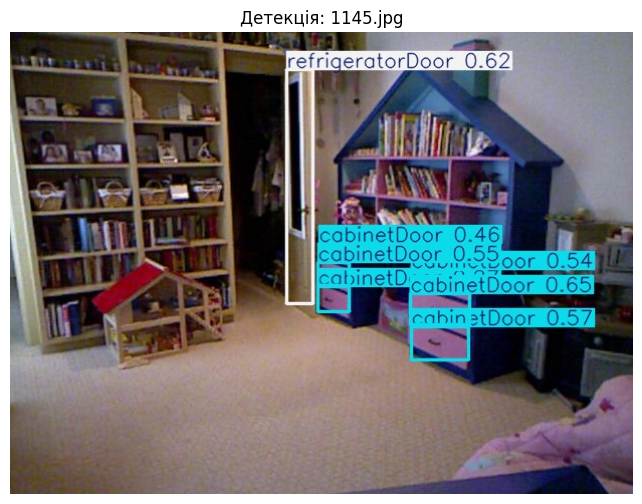

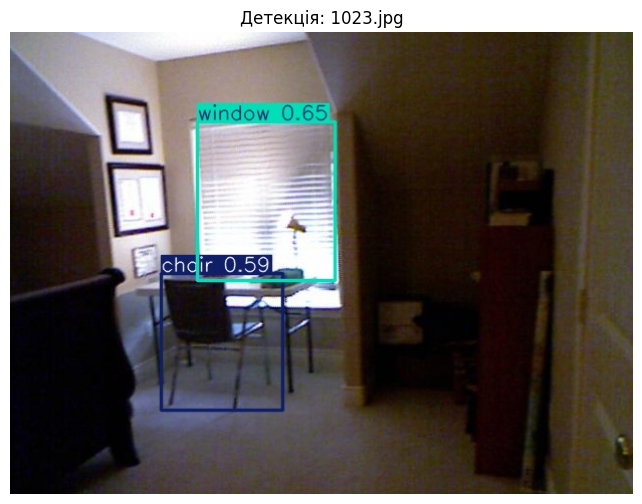

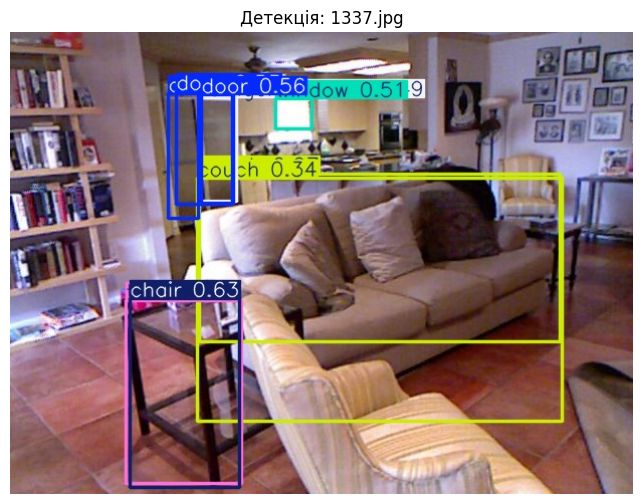

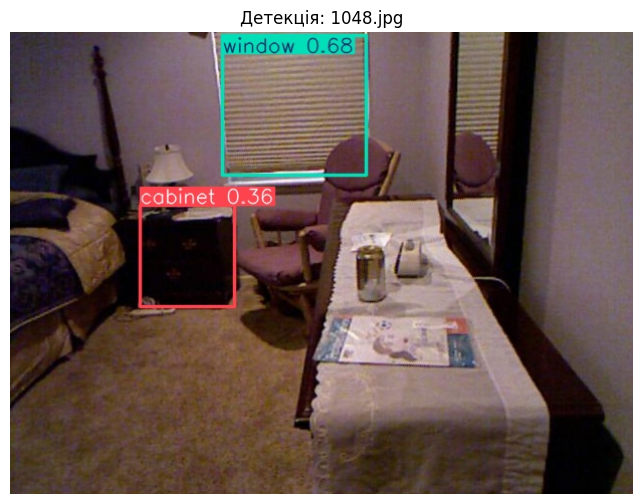

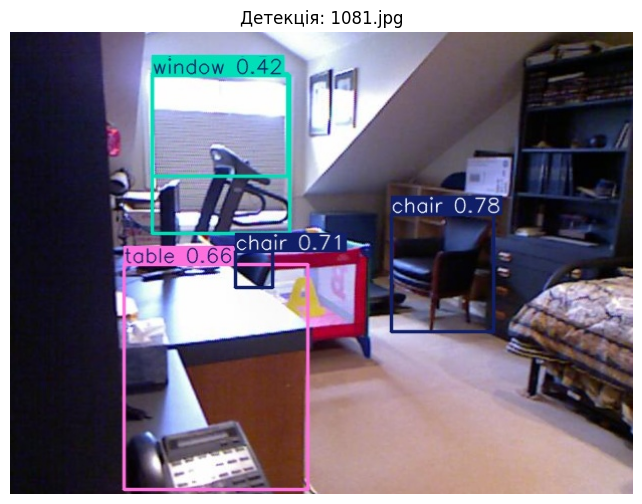

In [36]:
# –í–∏–±–∏—Ä–∞—î–º–æ 5 –∫–æ–Ω–∫—Ä–µ—Ç–Ω–∏—Ö –∑–æ–±—Ä–∞–∂–µ–Ω—å —ñ–∑ —Ç–µ—Å—Ç–æ–≤–æ—ó –ø–∞–ø–∫–∏ –¥–ª—è —ñ–Ω—Ñ–µ—Ä–µ–Ω—Å—É
image_paths = glob.glob('/kaggle/input/indoor-object-detection/test/images/*.png')[:5]

# –ü–∞–ø–∫–∞ –ø—Ä–æ—î–∫—Ç—É —Ç–∞ —ñ–º‚Äô—è –µ–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—É
project_dir = "/kaggle/working/indoor_yolo_training"
exp_name = "yolov8m_indoor_results"

# –†–æ–±–∏–º–æ —ñ–Ω—Ñ–µ—Ä–µ–Ω—Å: –∑–±–µ—Ä–µ–∂–µ–Ω–Ω—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ñ–≤ + –≤—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–Ω—è –ø–æ—Ä–æ–≥—É –≤–ø–µ–≤–Ω–µ–Ω–æ—Å—Ç—ñ
results = model.predict(
    source=image_paths,
    conf=0.25,
    save=True,
    project=project_dir,
    name=exp_name
)

# –¢–µ–ø–µ—Ä —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –∑–±–µ—Ä—ñ–≥–∞—é—Ç—å—Å—è —É /kaggle/working/indoor_yolo_training/yolov8l_indoor_results/
save_dir = os.path.join(project_dir, exp_name)

# –í—ñ–∑—É–∞–ª—ñ–∑–∞—Ü—ñ—è –∑–±–µ—Ä–µ–∂–µ–Ω–∏—Ö —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ñ–≤
for path in image_paths:
    filename = os.path.splitext(os.path.basename(path))[0] + ".jpg"  # –∑–º—ñ–Ω–∞ —Ç—É—Ç
    result_img_path = os.path.join(save_dir, filename)

    if os.path.exists(result_img_path):
        img = cv2.imread(result_img_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"–î–µ—Ç–µ–∫—Ü—ñ—è: {filename}")
        plt.axis('off')
        plt.show()
    else:
        print(f"[!] –ù–µ –∑–Ω–∞–π–¥–µ–Ω–æ –∑–±–µ—Ä–µ–∂–µ–Ω–µ –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è: {result_img_path}")


**–†–ï–ó–£–õ–¨–¢–ê–¢–ò** (–Ω–∞ –≤–∞–ª—ñ–¥–∞—Ü—ñ–π–Ω–æ–º—É –Ω–∞–±–æ—Ä—ñ)

**–ó–ê–ì–ê–õ–¨–ù–Ü –†–ï–ó–£–õ–¨–¢–ê–¢–ò –ü–û –ö–õ–ê–°–ê–•**
<br>mAP@0.5:                    0.4919
<br>mAP@0.5:0.95:               0.3319
<br>Precision (mean –ø–æ –∫–ª–∞—Å–∞—Ö): 0.6592
<br>Recall (mean –ø–æ –∫–ª–∞—Å–∞—Ö):    0.4038
<br>F1-score (mean –ø–æ –∫–ª–∞—Å–∞—Ö):  0.4486

**–ú–ï–¢–†–ò–ö–ò –ü–û –ö–õ–ê–°–ê–•:**

–ö–ª–∞—Å	                Precision	Recall	mAP@0.5	mAP@0.5:0.95
<br> door	            0.720	0.474	0.578	0.377
<br>cabinetDoor	        0.891	0.685	0.828	0.481
<br>refrigeratorDoor	0.883	0.709	0.837	0.558
<br>window	0.428	0.214	0.304	0.180
<br>chair	0.769	0.475	0.633	0.354
<br>table	0.490	0.200	0.238	0.126
<br>cabinet	0.762	0.281	0.399	0.288
<br>couch	0.648	1.000	0.995	0.896
<br>openedDoor	0.000	0.000	0.079	0.048
<br>pole	1.000	0.000	0.027	0.011

**–ù–∞–π–∫—Ä–∞—â—ñ –∫–ª–∞—Å–∏:**
<br>couch, refrigeratorDoor, cabinetDoor ‚Äî –≤–∏—Å–æ–∫–∞ —Ç–æ—á–Ω—ñ—Å—Ç—å, –ø–æ–≤–Ω–æ—Ç–∞ —ñ mAP@0.5:0.95

**–°–ª–∞–±–∫—ñ –∫–ª–∞—Å–∏:**
<br>openedDoor —Ç–∞ pole ‚Äî –º–∞–π–∂–µ –ø–æ–≤–Ω–∞ –≤—ñ–¥—Å—É—Ç–Ω—ñ—Å—Ç—å –∫–æ—Ä–µ–∫—Ç–Ω–æ–≥–æ –ø–µ—Ä–µ–¥–±–∞—á–µ–Ω–Ω—è
<br>window, table ‚Äî –ø–æ–≥–∞–Ω–∞ recall —ñ –Ω–∏–∑—å–∫–∞ —Ç–æ—á–Ω—ñ—Å—Ç—å

**–ü–†–û–ë–õ–ï–ú–ò, –í–ò–Ø–í–õ–ï–ù–Ü –ü–Ü–î –ß–ê–° –ê–ù–ê–õ–Ü–ó–£:**

<br>–î–∏—Å–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—ñ–≤:
<br>openedDoor, pole –º–∞—é—Ç—å –¥—É–∂–µ –º–∞–ª–æ –ø—Ä–∏–∫–ª–∞–¥—ñ–≤ —É —Ç—Ä–µ–Ω—É–≤–∞–ª—å–Ω–æ–º—É –Ω–∞–±–æ—Ä—ñ ‚Üí –º–æ–¥–µ–ª—å —ó—Ö –Ω–µ –≤–∏–≤—á–∞—î.

<br>–í—ñ–∑—É–∞–ª—å–Ω–∞ —Å—Ö–æ–∂—ñ—Å—Ç—å –∫–ª–∞—Å—ñ–≤:
<br>door, openedDoor, cabinetDoor ‚Äî –º–æ–¥–µ–ª—å –ø–ª—É—Ç–∞—î —á–µ—Ä–µ–∑ —Å—Ö–æ–∂—ñ —Ä–∏—Å–∏ (—Ñ–æ—Ä–º–∞, —Ç–µ–∫—Å—Ç—É—Ä–∞, –∫–æ–ª—å–æ—Ä–∏).

<br>Recall –ø–æ –±–∞–≥–∞—Ç—å–æ—Ö –∫–ª–∞—Å–∞—Ö –Ω–∏–∑—å–∫–∏–π:
<br>–ú–æ–¥–µ–ª—å —á–∞—Å—Ç–æ –Ω–µ –∑–Ω–∞—Ö–æ–¥–∏—Ç—å –æ–±‚Äô—î–∫—Ç–∏, –Ω–∞–≤—ñ—Ç—å —è–∫—â–æ –∑–Ω–∞—î, —è–∫ –≤–æ–Ω–∏ –≤–∏–≥–ª—è–¥–∞—é—Ç—å (–Ω–µ–¥–æ—Å—Ç–∞—Ç–Ω—è –≥–µ–Ω–µ—Ä–∞–ª—ñ–∑–∞—Ü—ñ—è).
<br>–ü—Ä–æ–±–ª–µ–º–∏ –∑ –¥—Ä—ñ–±–Ω–∏–º–∏ –∞–±–æ —á–∞—Å—Ç–∫–æ–≤–æ –ø—Ä–∏—Ö–æ–≤–∞–Ω–∏–º–∏ –æ–±'—î–∫—Ç–∞–º–∏.

**–©–û –ú–û–ñ–ù–ê –ü–û–ö–†–ê–©–ò–¢–ò:**

–ú–æ–¥–µ–ª—å / –ù–∞–≤—á–∞–Ω–Ω—è:
<br>1 –ü–µ—Ä–µ–π—Ç–∏ –¥–æ YOLOv8l –∞–±–æ YOLOv9 - –±—É–ª–∏ —Å–ø—Ä–æ–±–∏ –Ω–∞–≤—á–∞–Ω–Ω—è —Ä—ñ–∑–Ω–∏—Ö –º–æ–¥–µ–ª–µ–π, –∞–ª–µ –Ω–∞ –∫–æ—Ä–æ—Ç–∫—ñ–π –≤—ñ–¥—Å—Ç–∞–Ω—ñ (25-30 –µ–ø–æ—Ö) —Ü–µ –Ω–µ –Ω–∞–¥–∞–ª–æ –≤—ñ–¥—á—É—Ç–Ω–∏—Ö —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ñ–≤.
<br>–ó–±—ñ–ª—å—à–∏—Ç–∏ imgsz=768 –∞–ª–µ –ø—Ä–∏ —É–º–æ–≤—ñ –∑–±—ñ–ª—å—à–µ–Ω–Ω—è –¥–æ —Ä–æ–∑–º—ñ—Ä—É imgsz=960 ‚Äî –ø–æ—Ç—Ä—ñ–±–Ω–æ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É–≤–∞—Ç–∏ –ø–æ—Ç—É–∂–Ω–∏–π –ü–ö —Ç–∞–∫ —è–∫ —Å–µ—Ä–µ–¥–Ω—ñ–π –Ω–µ –≤–∏—Ç—è–≥—É—é - —Ü–µ –º–æ–∂–ª–∏–≤–æ –¥–∞—Å—Ç—å –º–æ–¥–µ–ª—ñ –±—ñ–ª—å—à–µ –∫–æ–Ω—Ç–µ–∫—Å—Ç—É.
<br>–ó–±—ñ–ª—å—à–∏—Ç–∏ epochs=80‚Äì100 –∑ early stopping.
<br>–ù–∞–ª–∞—à—Ç—É–≤–∞—Ç–∏ class weights –∞–±–æ –∑—Ä–æ–±–∏—Ç–∏ oversampling –¥–ª—è openedDoor, pole.


–î–∞–Ω—ñ:
<br>–î–æ–¥–∞—Ç–∏ –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è –∞–±–æ –∑–≥–µ–Ω–µ—Ä—É–≤–∞—Ç–∏ –∞—É–≥–º–µ–Ω—Ç–æ–≤–∞–Ω—ñ –ø—Ä–∏–∫–ª–∞–¥–∏ –¥–ª—è —Ä—ñ–¥–∫—ñ—Å–Ω–∏—Ö –∫–ª–∞—Å—ñ–≤ (openedDoor, pole).
<br>–°—Ç–≤–æ—Ä–∏—Ç–∏ –≤–ª–∞—Å–Ω—É –∫–ª–∞—Å–æ–≤—É —ñ—î—Ä–∞—Ä—Ö—ñ—é, –Ω–∞–ø—Ä–∏–∫–ª–∞–¥ –æ–±'—î–¥–Ω–∞—Ç–∏ door + openedDoor, —è–∫—â–æ –∑–∞–¥–∞—á–∞ –¥–æ–ø—É—Å–∫–∞—î.

<br>–ú–µ—Ç—Ä–∏–∫–∏:
<br>–î–æ–¥–∞—Ç–∏ F1-score per class ‚Äî –¥–æ–∑–≤–æ–ª–∏—Ç—å –∫—Ä–∞—â–µ —Ä–æ–∑—É–º—ñ—Ç–∏ –±–∞–ª–∞–Ω—Å precision/recall.
<br>–ü—Ä–æ–≤–µ—Å—Ç–∏ confusion matrix –ø–æ –∫–ª–∞—Å–∞—Ö ‚Äî –≤—ñ–∑—É–∞–ª—å–Ω–æ –≤–∏–∑–Ω–∞—á–∏—Ç–∏, —â–æ –º–æ–¥–µ–ª—å –ø–ª—É—Ç–∞—î.

**–ó–ê–ì–ê–õ–¨–ù–ò–ô –í–ò–°–ù–û–í–û–ö**

–ë—É–ª–æ –ø–æ–±—É–¥—É–≤–∞–Ω–æ —Ä–æ–±–æ—á–∏–π –ø—Ä–æ—Ç–æ—Ç–∏–ø —Å–∏—Å—Ç–µ–º–∏ –æ–±'—î–∫—Ç–Ω–æ–≥–æ —Ä–æ–∑–ø—ñ–∑–Ω–∞–≤–∞–Ω–Ω—è —É –ø—Ä–∏–º—ñ—â–µ–Ω–Ω—ñ –Ω–∞ –æ—Å–Ω–æ–≤—ñ YOLOv8m, —è–∫–∏–π:
<br>–í–∏—è–≤–ª—è—î –æ—Å–Ω–æ–≤–Ω—ñ –∫–ª–∞—Å–∏ –∑ —Ö–æ—Ä–æ—à–æ—é —Ç–æ—á–Ω—ñ—Å—Ç—é.
<br>–ú–∞—î –ø–æ—Ç–µ–Ω—Ü—ñ–∞–ª –¥–æ –ø–æ–∫—Ä–∞—â–µ–Ω–Ω—è –∑–∞ —Ä–∞—Ö—É–Ω–æ–∫ –∑–±—ñ–ª—å—à–µ–Ω–Ω—è –µ–ø–æ—Ö, —Ä–æ–∑–º—ñ—Ä—É –∑–æ–±—Ä–∞–∂–µ–Ω—å —Ç–∞ —Ä–æ–±–æ—Ç–∏ –∑ –¥–∞–Ω–∏–º–∏.
<br>–ì–æ—Ç–æ–≤–∏–π –¥–ª—è —ñ–Ω—Ç–µ–≥—Ä–∞—Ü—ñ—ó –∞–±–æ —è–∫ –æ—Å–Ω–æ–≤–∞ –¥–ª—è –ø–æ–¥–∞–ª—å—à–∏—Ö –¥–æ—Å–ª—ñ–¥–∂–µ–Ω—å/–Ω–∞–≤—á–∞–Ω–Ω—è.